# Brecha de género

En este documento queremos analizar la diferencia de sueldos entre hombres y mujeres, cuánto de ella podemos explicar con las respuestas de la encuesta, por ejemplo considerando si un grupo tiene mayor experiencia laboral que otro. También usar encuestas pasadas para analizar la tendencia.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, recall_score, precision_score, balanced_accuracy_score
import scipy

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df.head()

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,NaN,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,NaN,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN


In [3]:
pd.DataFrame(df.keys())

,0
0,Me identifico
1,Tengo
2,Dónde estás trabajando
3,Años de experiencia
4,Años en la empresa actual
5,Años en el puesto actual
6,¿Gente a cargo?
7,Nivel de estudios alcanzado
8,Estado
9,Carrera


In [4]:
df['Me identifico'].value_counts()

Hombre    4922
Mujer      820
Otros       24
Name: Me identifico, dtype: int64

Lamentablemente hay muy pocas respuestas que no son hombre o mujer y no alcanzan los datos para sacar conclusiones, así que descartaré esos datos desde acá.

In [3]:
df = df[df['Me identifico'] != 'Otros']

In [4]:
ch = '#FF7F0E'
cm = '#1F77B4'

In [35]:
(
df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(),
df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(),
)

(77000.0, 62050.0)

In [53]:
df['Me identifico'].value_counts()

Hombre    4922
Mujer      820
Name: Me identifico, dtype: int64

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '(a) distribución de sueldo por género')

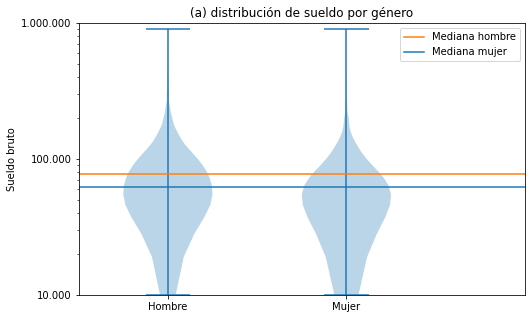

In [5]:
_, ax0 = plt.subplots(1, 1, figsize=(8, 5));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(), c=cm)
ax0.set_ylabel('Sueldo bruto')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Hombre', 'Mujer'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].values,
    df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].values,
]);
ax0.legend(['Mediana hombre', 'Mediana mujer'])
ax0.set_title('(a) distribución de sueldo por género')


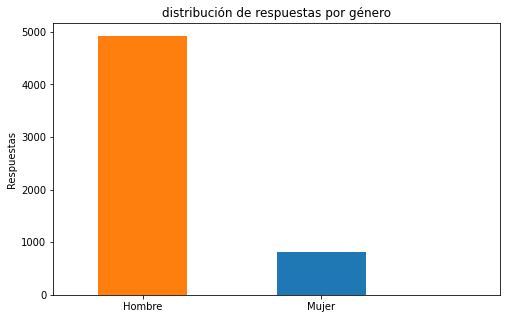

In [6]:
_, ax1 = plt.subplots(1, 1, figsize=(8, 5));
df['Me identifico'].value_counts().sort_values(ascending=False).plot.bar(color=[ch, cm], ax=ax1, rot=0);
ax1.set_xlim(-0.5, 2)
ax1.set_title('distribución de respuestas por género')
ax1.set_ylabel('Respuestas');

In [7]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])

In [72]:
df[df['Me identifico'] == 'Mujer']['region'].value_counts()

AMBA         675
Pampa        110
Cuyo          14
NEA           12
NOA            5
Patagonia      4
Name: region, dtype: int64

In [8]:
regions = ['AMBA', 'Pampa']

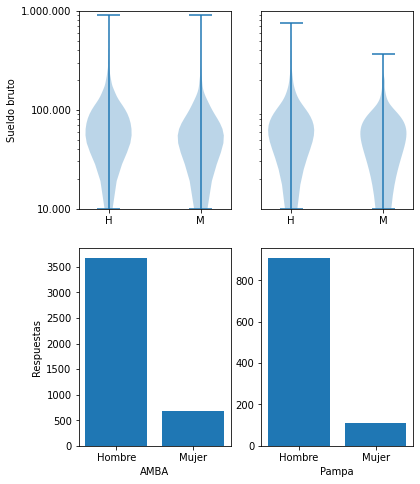

In [9]:
f, axs = plt.subplots(2, len(regions), figsize=(3*len(regions), 8))
for i, region in enumerate(regions):
    ax = plt.subplot(2, len(regions), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(regions), i+1+len(regions))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(region)
    s = df[df['region'] == region]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [9]:
degrees = df[df['Me identifico'] == 'Mujer']['Carrera'].value_counts()
degrees = degrees[degrees > 25].keys().to_list()

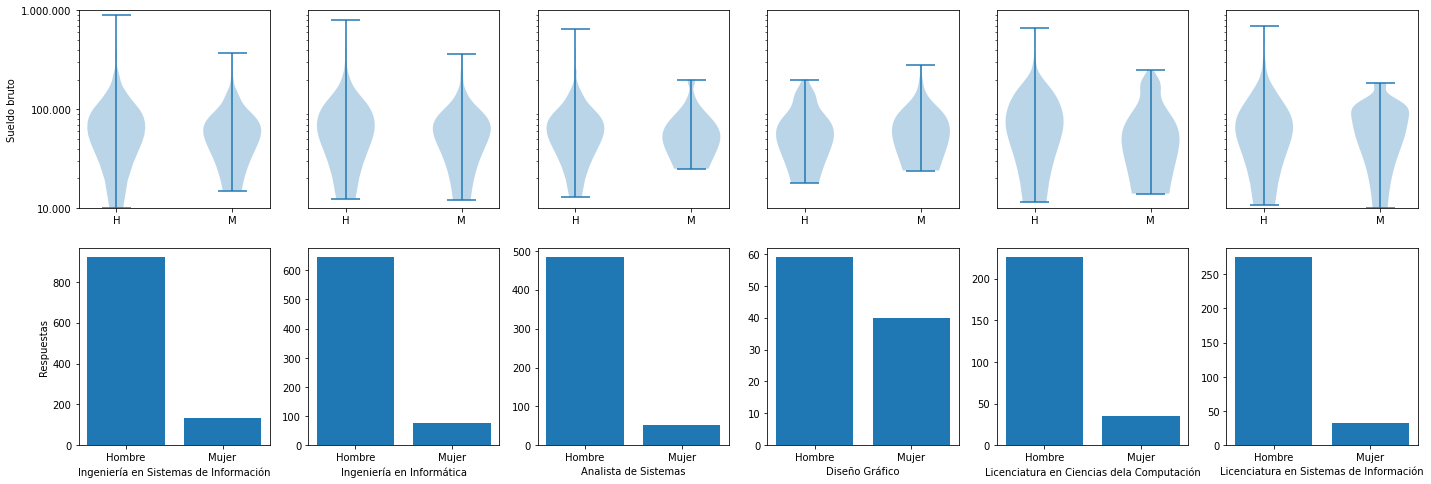

In [11]:
f, axs = plt.subplots(2, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(2, len(degrees), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(degrees), i+1+len(degrees))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(degree)
    s = df[df['Carrera'] == degree]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [10]:
df['log2(exp)'] = df['Años de experiencia'].apply(lambda x: math.floor(math.log(x+1, 2)))
df['log2(exp)'].value_counts()

3    1769
2    1487
4    1133
1     868
0     448
5      37
Name: log2(exp), dtype: int64

In [11]:
exps = sorted(df['log2(exp)'].unique())
exps

[0, 1, 2, 3, 4, 5]

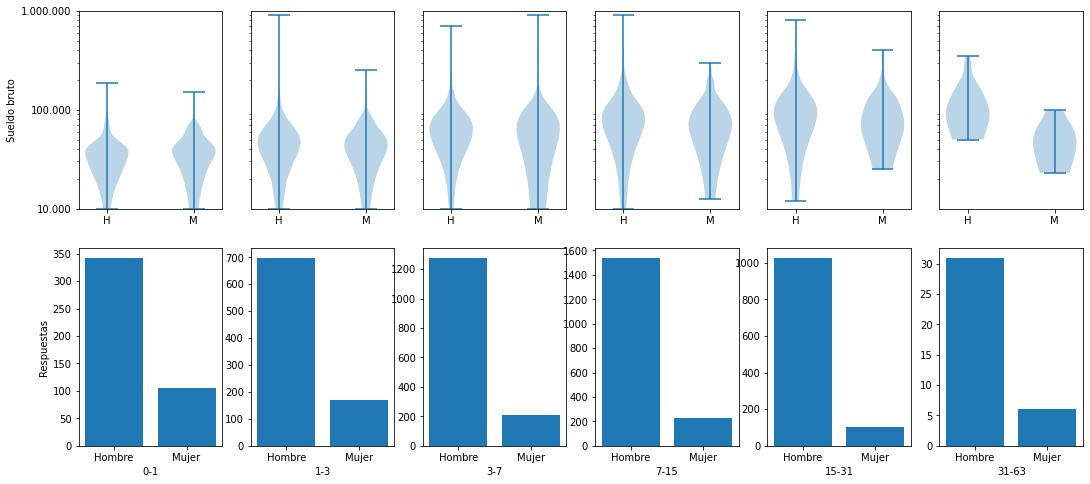

In [14]:
f, axs = plt.subplots(2, len(exps),figsize=(3*len(exps), 8))
for i, exp in enumerate(exps):
    ax = plt.subplot(2, len(exps), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(degrees), i+1+len(degrees))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    s = df[df['log2(exp)'] == exp]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [12]:
occupations = df[df['Me identifico'] == 'Mujer']['Trabajo de'].value_counts()
occupations = occupations[occupations > 25].keys().to_list()

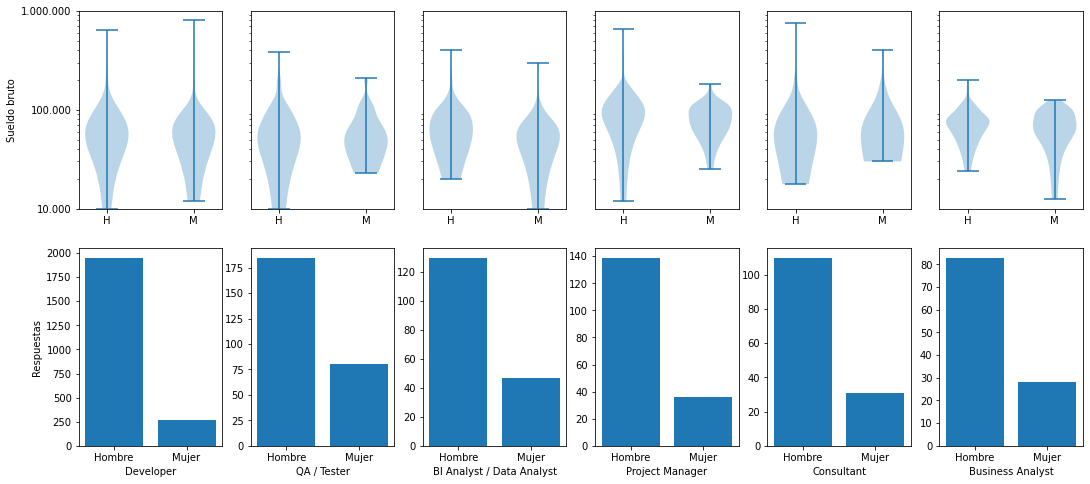

In [16]:
f, axs = plt.subplots(2, len(occupations),figsize=(3*len(occupations), 8))
for i, occupation in enumerate(occupations):
    ax = plt.subplot(2, len(occupations), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(occupations), i+1+len(occupations))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(occupation)
    s = df[df['Trabajo de'] == occupation]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

## Analizar la brecha de género

El sueldo depende de muchas cosas y es difícil de determinar. Si vemos una disparidad en los sueldos de por ejemplo BI, o de gente con más experiencia, es difícil establecer la causalidad para medirlos. Lo que podemos hacer es usar un modelo que establezca cuánto ganaría cada persona que respondió la encuesta al cambiarle su género, tomando el supuesto de que el modelo puede encontrar estas relaciones entre las distintas características.

In [13]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
class Model:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'])
    df.loc[df.index[test_index], 'e(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h(salary)'] = df.apply(lambda row: row['e(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr(salary)'], axis=1)
df['e_m(salary)'] = df.apply(lambda row: row['e(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr(salary)'], axis=1)
df['e_g_diff(salary)'] = (df['e_h(salary)'] - df['e_m(salary)']) / df['e_h(salary)']

In [17]:
(df['e_h(salary)'].median(), df['e_m(salary)'].median())

(80492.9296875, 74243.13671875)

In [19]:
df[df['Me identifico'] == 'Hombre']['e_h(salary)'].median(),df[df['Me identifico'] == 'Mujer']['e_h(salary)'].median()

(81518.89453125, 74263.00390625)

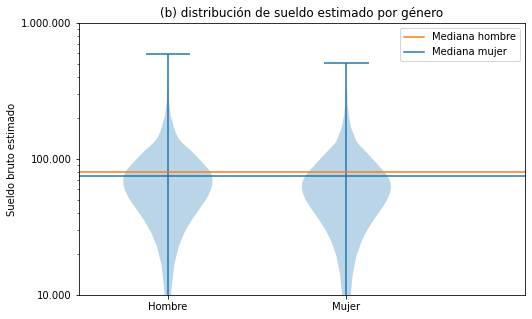

In [15]:
_, (ax0) = plt.subplots(1, 1, figsize=(8, 5));
ax0.axhline(df['e_h(salary)'].median(), c=ch)
ax0.axhline(df['e_m(salary)'].median(), c=cm)
ax0.set_ylabel('Sueldo bruto estimado')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Hombre', 'Mujer'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df['e_h(salary)'].values,
    df['e_m(salary)'].values,
]);
ax0.legend(['Mediana hombre', 'Mediana mujer'])
ax0.set_title('(b) distribución de sueldo estimado por género');

In [19]:
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?",region,log2(exp),e(salary),e_gr(salary),e_h(salary),e_m(salary),e_g_diff(salary)
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN,NOA,4,37615.613281,28677.974609,37615.613281,28677.974609,0.237604
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,2.0,Abono de celular y/o Internet,NaN,NOA,4,67595.273438,81589.476562,81589.476562,67595.273438,0.171520
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN,NEA,3,189327.171875,130653.671875,189327.171875,130653.671875,0.309905
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN,NEA,4,252361.765625,226813.109375,252361.765625,226813.109375,0.101238
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN,NEA,2,57168.390625,49509.304688,57168.390625,49509.304688,0.133974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,Hombre,40,Tucumán,9.0,2.0,1.0,2,Universitario,Completado,Licenciatura en Informática,...,-1.0,Ninguna de las anteriores,Ninguna,NOA,3,42692.351562,37435.167969,42692.351562,37435.167969,0.123141
5977,Hombre,33,Tucumán,4.0,0.0,0.0,0,Terciario,Incompleto,Analista de Sistemas,...,1.0,"Capacitaciones y/o cursos, Clases de idiomas","Ninguna, todas son una mierda.",NOA,2,51496.289062,50807.019531,51496.289062,50807.019531,0.013385
5978,Hombre,26,Tucumán,4.0,4.0,4.0,1,Terciario,En curso,Tecnicatura en Programación,...,10.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",Everis globant sovos,NOA,2,62749.019531,67353.125000,62749.019531,67353.125000,-0.073373
5979,Hombre,32,Tucumán,11.0,11.0,11.0,0,Terciario,Completado,Prof. Educación Tecnologica,...,3.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN,NOA,3,38604.453125,37834.539062,38604.453125,37834.539062,0.019944


In [50]:
df['e_g_diff(salary)'].mean()

0.06923028368241625

El modelo aprendiendo de los datos de la encuesta de sueldos concluyó que en promedio le tiene que pagar un 6.92% más a los hombres que a las mujeres, siendo el resto de las respuestas iguales.

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


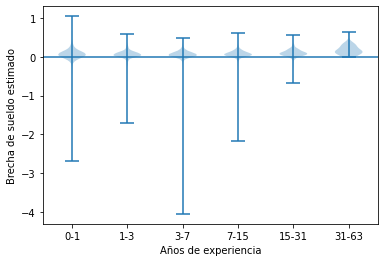

In [21]:
f, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xlabel('Años de experiencia')
ax.set_xticks([e+1 for e in exps])
ax.set_xticklabels([f'{2**exp-1}-{2**(1+exp)-1}' for exp in exps])
ax.axhline()
ax.violinplot([
    df[df['log2(exp)'] == exp]['e_g_diff(salary)'].values
    for exp in exps
]);

El modelo parece haber aprendido que mientras mayor es la experiencia de la persona, mayor debe ser la diferencia entre hombres y mujeres. Esto puede deberse a que los datos muestren un [techo de cristal](https://es.wikipedia.org/wiki/Techo_de_cristal).

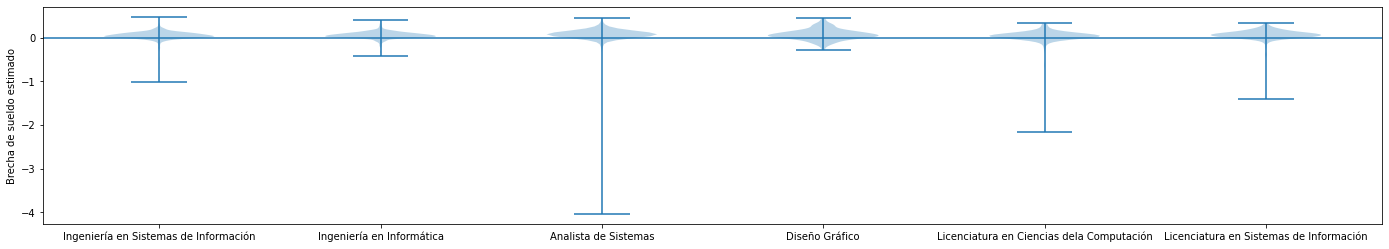

In [22]:
f, axs = plt.subplots(1, 1, figsize=(24, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xticks([e+1 for e, _ in enumerate(degrees)])
ax.set_xticklabels(degrees)
ax.axhline()
ax.violinplot([
    df[df['Carrera'] == degree]['e_g_diff(salary)'].values
    for degree in degrees
]);

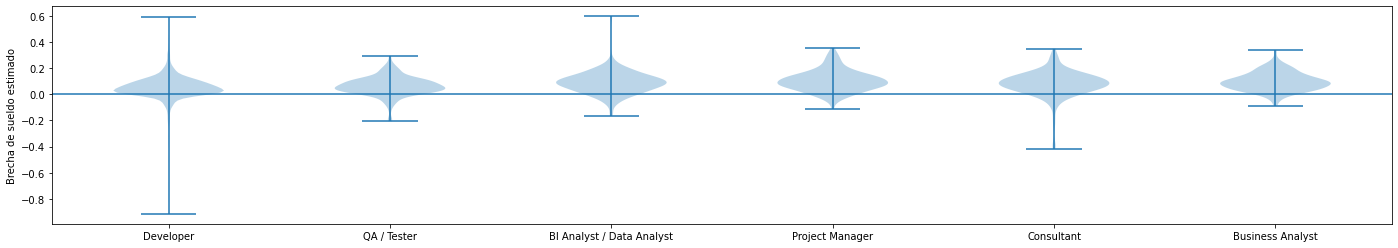

In [23]:
f, axs = plt.subplots(1, 1, figsize=(24, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xticks([e+1 for e, _ in enumerate(occupations)])
ax.set_xticklabels(occupations)
ax.axhline()
ax.violinplot([
    df[df['Trabajo de'] == occupation]['e_g_diff(salary)'].values
    for occupation in occupations
]);

## Modelo "gender-blind"

Creemos ahora un modelo que no considere explicitamente el género y veamos qué pasa con las estimaciones de sueldo de los hombres y de las mujeres comparadas con las estimaciones que lo toman en cuenta (del modelo "gender-aware").

In [13]:
df['Me identifico_copy'] = df['Me identifico']
df['Me identifico'] = ''
df['Orientación sexual_copy'] = df['Orientación sexual']
df['Orientación sexual'] = ''
df['Tengo_copy'] = df['Tengo']
df['Tengo'] = 0
kf = KFold(n_splits=5, shuffle=True, random_state=99)
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'])
    df.loc[df.index[test_index], 'e_gb(salary)'] = model.predict(df.iloc[test_index])
df['Me identifico'] = df['Me identifico_copy']
df['Orientación sexual'] = df['Orientación sexual_copy']
df['Tengo'] = df['Tengo_copy']
df['e_gb_diff(salary)'] = (df['e(salary)'] - df['e_gb(salary)']) / df['e(salary)']

In [14]:
(
df['e_gb_diff(salary)'].mean(),
df[(df['Me identifico'] == 'Hombre')]['e_gb_diff(salary)'].mean(),
df[(df['Me identifico'] == 'Mujer')]['e_gb_diff(salary)'].mean(),
)

(-0.014923921340988173, -0.010692551936539136, -0.040322458180863975)

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


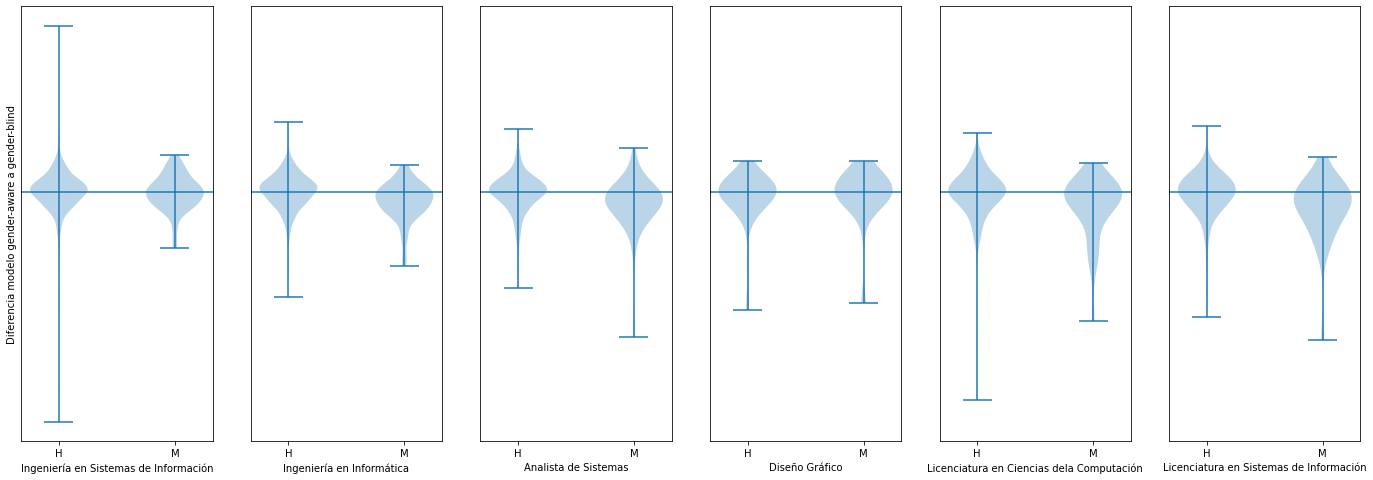

In [15]:
ax = None
f, axs = plt.subplots(1, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(degree)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['e_gb_diff(salary)'].values,
    ]);

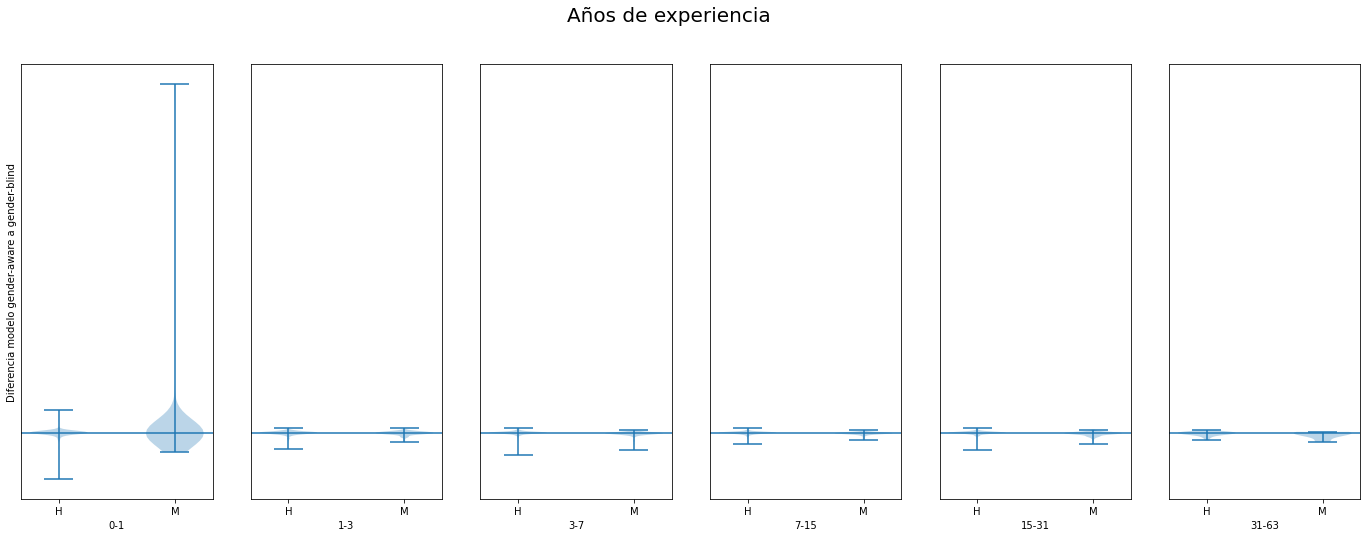

In [16]:
ax = None
f, axs = plt.subplots(2, len(exps),figsize=(4*len(exps), 8))
f.suptitle('Años de experiencia', fontsize=20)
for i, exp in enumerate(exps):
    ax = plt.subplot(1, len(exps), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(exp)
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['e_gb_diff(salary)'].values,
    ]);

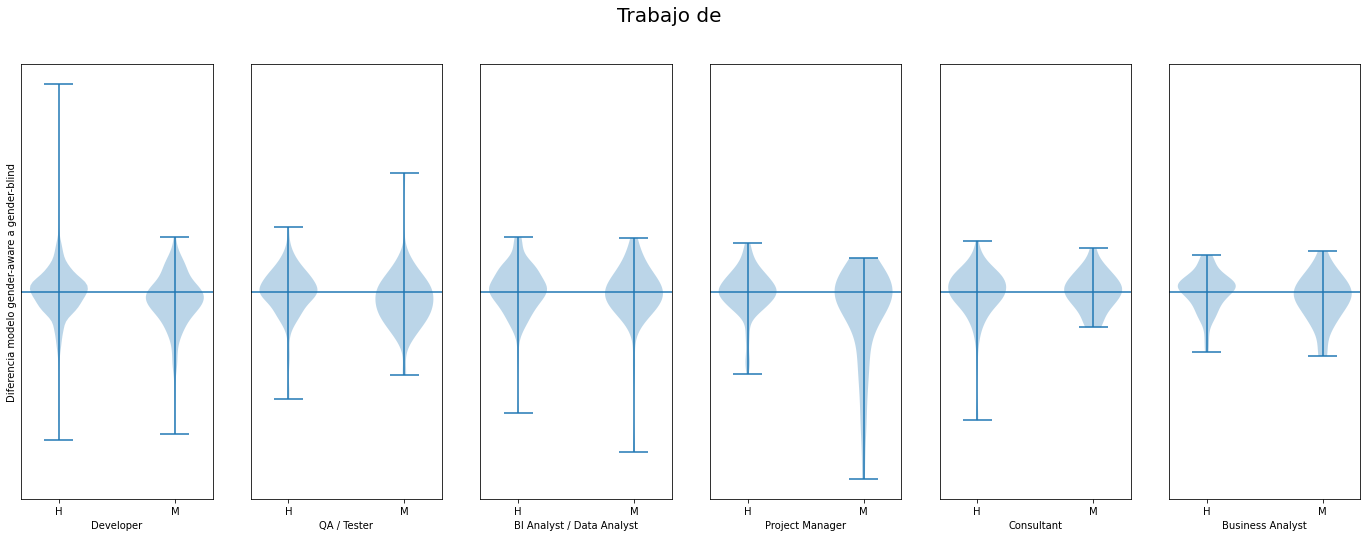

In [17]:
ax = None
f, axs = plt.subplots(1, len(occupations),figsize=(4*len(occupations), 8))
f.suptitle('Trabajo de', fontsize=20)
for i, occupation in enumerate(occupations):
    ax = plt.subplot(1, len(occupations), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(occupation)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['e_gb_diff(salary)'].values,
    ]);

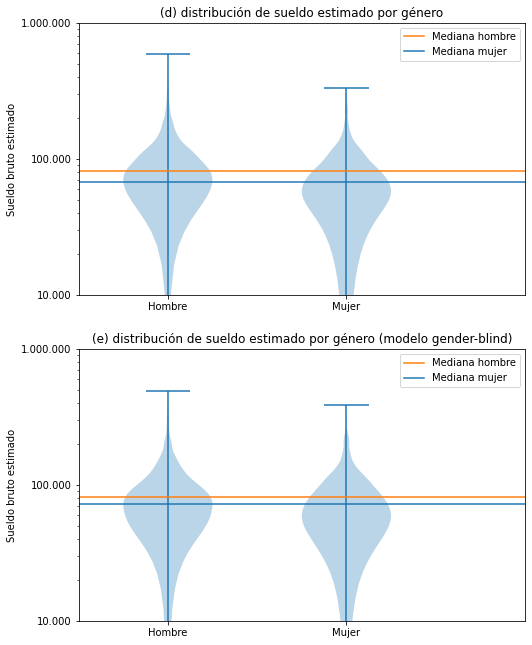

In [27]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 11));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['e(salary)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['e(salary)'].median(), c=cm)
ax0.set_ylabel('Sueldo bruto estimado')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Hombre', 'Mujer'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df[df['Me identifico'] == 'Hombre']['e(salary)'].values,
    df[df['Me identifico'] == 'Mujer']['e(salary)'].values,
]);
ax0.legend(['Mediana hombre', 'Mediana mujer'])
ax0.set_title('(d) distribución de sueldo estimado por género');

ax1.axhline(df[df['Me identifico'] == 'Hombre']['e_gb(salary)'].median(), c=ch)
ax1.axhline(df[df['Me identifico'] == 'Mujer']['e_gb(salary)'].median(), c=cm)
ax1.set_ylabel('Sueldo bruto estimado')
ax1.set_yscale('log')
ax1.set_xlim(0.5, 3)
ax1.set_ylim(10_000, 1_000_000)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Hombre', 'Mujer'])
ax1.set_yticks([10_000, 100_000, 1_000_000])
ax1.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax1.violinplot([
    df[df['Me identifico'] == 'Hombre']['e_gb(salary)'].values,
    df[df['Me identifico'] == 'Mujer']['e_gb(salary)'].values,
]);
ax1.legend(['Mediana hombre', 'Mediana mujer'])
ax1.set_title('(e) distribución de sueldo estimado por género (modelo gender-blind)');

In [30]:
(
df[df['Me identifico'] == 'Hombre']['e(salary)'].median(),
df[df['Me identifico'] == 'Mujer']['e(salary)'].median(),
df[df['Me identifico'] == 'Hombre']['e_gb(salary)'].median(),
df[df['Me identifico'] == 'Mujer']['e_gb(salary)'].median()
)

(81518.89453125, 67600.87109375, 81214.0625, 71858.4765625)

Al excluir el género en el modelo el sueldo estimado de los mujeres se aumenta más que el de los hombres, pero la brecha persiste.

### Explicar la diferencia

Vemos que el modelo aprendió que las mujeres por el mismo trabajo tienen que ganar menos, y no sólo eso, cuando le escondemos el género la diferencia se incrementa. Vamos a tratar de ver qué están viendo los modelos para ver qué características cobran más importancia al ser gender-blind. También podemos intentar comparar una versión de modelo sólo para hombres con una sólo de mujeres y ver en qué se fijan en cada caso.

In [18]:
models = {}
df['Me identifico_copy'] = df['Me identifico']
df['Orientación sexual_copy'] = df['Orientación sexual']
df['Tengo_copy'] = df['Tengo']

models['gender-aware'] = Model().fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
df['Me identifico'] = ''
df['Orientación sexual'] = ''
df['Tengo'] = 0
models['gender-unaware'] = Model().fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
df['Me identifico'] = df['Me identifico_copy']
df['Orientación sexual'] = df['Orientación sexual_copy']
df['Tengo'] = df['Tengo_copy']

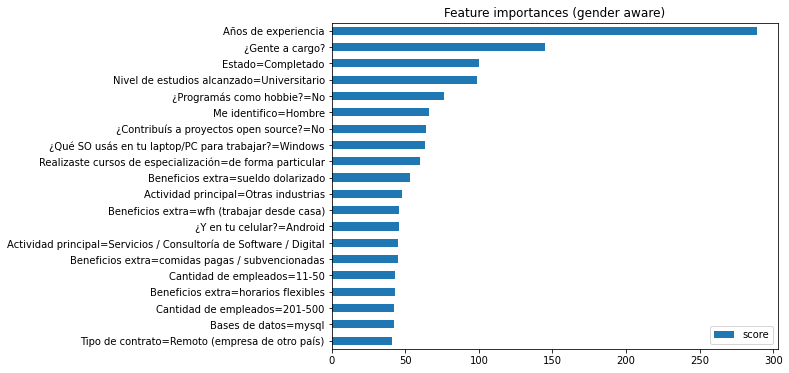

In [19]:
features = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True).tail(20)
data.plot(kind='barh', figsize=(8, 6), title='Feature importances (gender aware)');

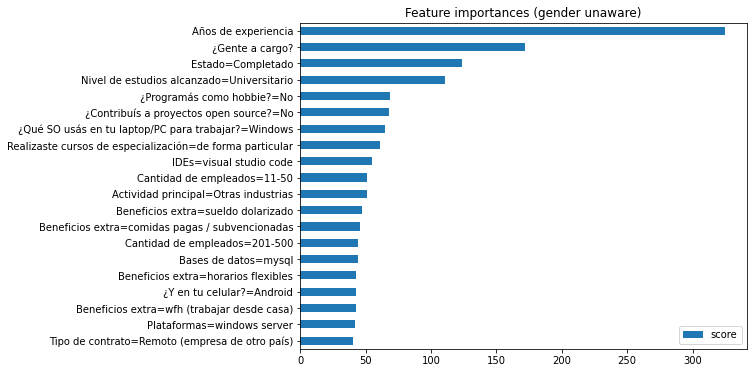

In [20]:
features = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True).tail(20)
data.plot(kind='barh', figsize=(8, 6), title='Feature importances (gender unaware)');

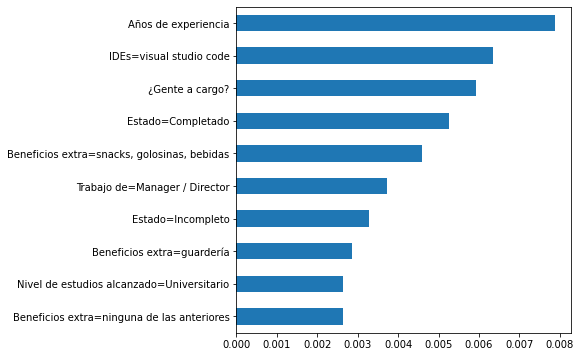

In [21]:
scores = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
sum_scores = sum(scores.values())
f = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important_aw = {f[int(k)]: v / sum_scores for k, v in scores.items()}

scores = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
sum_scores = sum(scores.values())
f = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important_unaw = {f[int(k)]: v / sum_scores for k, v in scores.items()}

diff = pd.Series({k: np.abs(v - feature_important_aw.get(k, 0)) for k, v in feature_important_unaw.items()}).sort_values()
plt.subplots(1, 1, figsize=(6, 6))
diff.tail(10).plot.barh(ax=plt.subplot(1,1,1));

Cuando le sacamos género al modelo (unaware) la importancia se diluye en el resto de las características sin que ninguna prevalezca. No existe una característica que funcione como [proxy](https://en.wikipedia.org/wiki/Proxy_(statistics)) claro.

## Cuán injustamente malo es el modelo

El modelo es el mejor modelo que pudimos lograr. Tiene un r2 de 0.6244, lo que quiere decir que no puede explicar un 38%. Todavía más podemos ver cómo si el error que comete es igual para hombres que para mujeres, y no sólo eso sino que ya vimos que las estimaciones para mujeres son un 7% inferiores que la de los hombres. Como en la muestra que tenemos hay menos mujeres que hombres (menos de un 15% del total) sabemos que el modelo priorizó la precisión de los hombres, por priorizar la precisión total.

In [38]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Hombre']['e(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Mujer']['e(salary)']))
print('r2 total', r2_score(df['Salario mensual BRUTO (en tu moneda local)'], df['e(salary)']))

r2 hombre 0.48759778750796845
r2 mujer 0.41390921876504094
r2 total 0.48440678836445183


El error de predicción debería ser normal si el modelo no está sesgado. Veamos qué pasa por género.

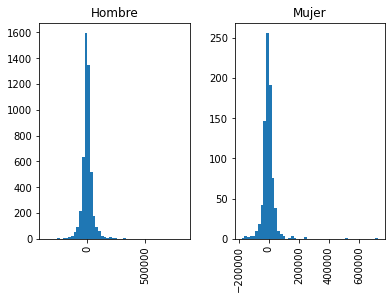

In [39]:
df['e(salary)_err'] = (df['Salario mensual BRUTO (en tu moneda local)'] - df['e(salary)'])
df.hist(column='e(salary)_err', bins=50, by=df['Me identifico']);

In [40]:
(
scipy.stats.normaltest(df['e(salary)_err']),
scipy.stats.normaltest(df[df['Me identifico'] == 'Hombre']['e(salary)_err']),
scipy.stats.normaltest(df[df['Me identifico'] == 'Mujer']['e(salary)_err']),
)

(NormaltestResult(statistic=5397.678780756876, pvalue=0.0),
 NormaltestResult(statistic=4445.020751652264, pvalue=0.0),
 NormaltestResult(statistic=1032.4706557077125, pvalue=6.336446166998089e-225))

In [41]:
print(f"total mean={np.mean(df['e(salary)_err'])}, var={np.var(df['e(salary)_err'])}")
print(f"hombres mean={np.mean(df[df['Me identifico'] == 'Hombre']['e(salary)_err'])}, var={np.var(df[df['Me identifico'] == 'Hombre']['e(salary)_err'])}")
print(f"mujeres mean={np.mean(df[df['Me identifico'] == 'Mujer']['e(salary)_err'])}, var={np.var(df[df['Me identifico'] == 'Mujer']['e(salary)_err'])}")

total mean=-583.5801707309149, var=2831102298.9056816
hombres mean=-433.8276157500366, var=2918476322.7753477
mujeres mean=-1482.4607507502858, var=2305702452.351776


El error en ambos grupos es normal con media cero, pero para las mujeres presenta es un poco menos normal y tiene más varianza.

Probemos aumentarle un 7% el sueldo a todas las mujeres y ver su efecto en la calidad de los resultados.

In [44]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Hombre']['e(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Mujer']['e(salary)'] * 1.07))
print('r2 total', r2_score(df['Salario mensual BRUTO (en tu moneda local)'], df.apply(lambda row: row['e(salary)'] * (1.0 if row['Me identifico'] == 'Hombre' else 1.07), axis=1)))

r2 hombre 0.48759778750796845
r2 mujer 0.39092562607035686
r2 total 0.4820532564448732


El r2 baja, como era esperable, pero bastante poco. El r2 de mujeres también baja, más, y esto se explica porque le estamos agregando un error sistemático, haciendo [discriminación positiva](https://es.wikipedia.org/wiki/Discriminaci%C3%B3n_positiva).

## Hacia un modelo más justo

Que el error sea mayor con las mujeres puede deberse a que sean menos, y por lo tanto su peso en la evaluación de la inferencia es menor. Podemos compensar esta asimetría considerando a cada mujer como si apareciese seis veces.

In [13]:
men_per_woman = df['Me identifico'].value_counts()['Hombre'] / df['Me identifico'].value_counts()['Mujer']

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'],
                       sample_weight=df.iloc[train_index]['Me identifico'].apply(lambda g: 1.0 if g == 'Hombre' else men_per_woman))
    df.loc[df.index[test_index], 'e_weighted(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr_weighted(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h_weighted(salary)'] = df.apply(lambda row: row['e_weighted(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr_weighted(salary)'], axis=1)
df['e_m_weighted(salary)'] = df.apply(lambda row: row['e_weighted(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr_weighted(salary)'], axis=1)
df['e_g_diff_weighted(salary)'] = (df['e_h_weighted(salary)'] - df['e_m_weighted(salary)']) / df['e_h_weighted(salary)']

In [21]:
(
df['e_g_diff_weighted(salary)'].mean(),
df[(df['Me identifico'] == 'Hombre')]['e_g_diff_weighted(salary)'].mean(),
df[(df['Me identifico'] == 'Mujer')]['e_g_diff_weighted(salary)'].mean(),
)

(0.05771188169827673, 0.05480982674103237, 0.07513128962456535)

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


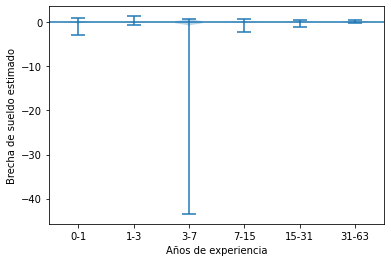

In [24]:
f, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xlabel('Años de experiencia')
ax.set_xticks([e+1 for e in exps])
ax.set_xticklabels([f'{2**exp-1}-{2**(1+exp)-1}' for exp in exps])
ax.axhline()
ax.violinplot([
    df[df['log2(exp)'] == exp]['e_g_diff_weighted(salary)'].values
    for exp in exps
]);

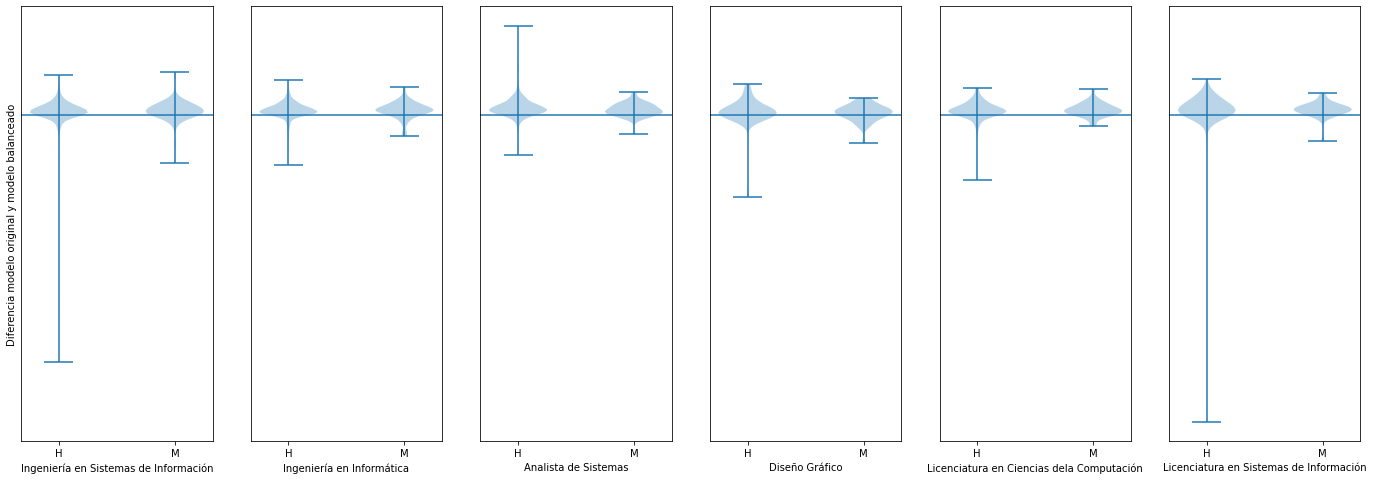

In [25]:
ax = None
f, axs = plt.subplots(1, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo original y modelo balanceado')
    else:
        ax.set_yticks([])
    ax.set_xlabel(degree)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['e_g_diff_weighted(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['e_g_diff_weighted(salary)'].values,
    ]);

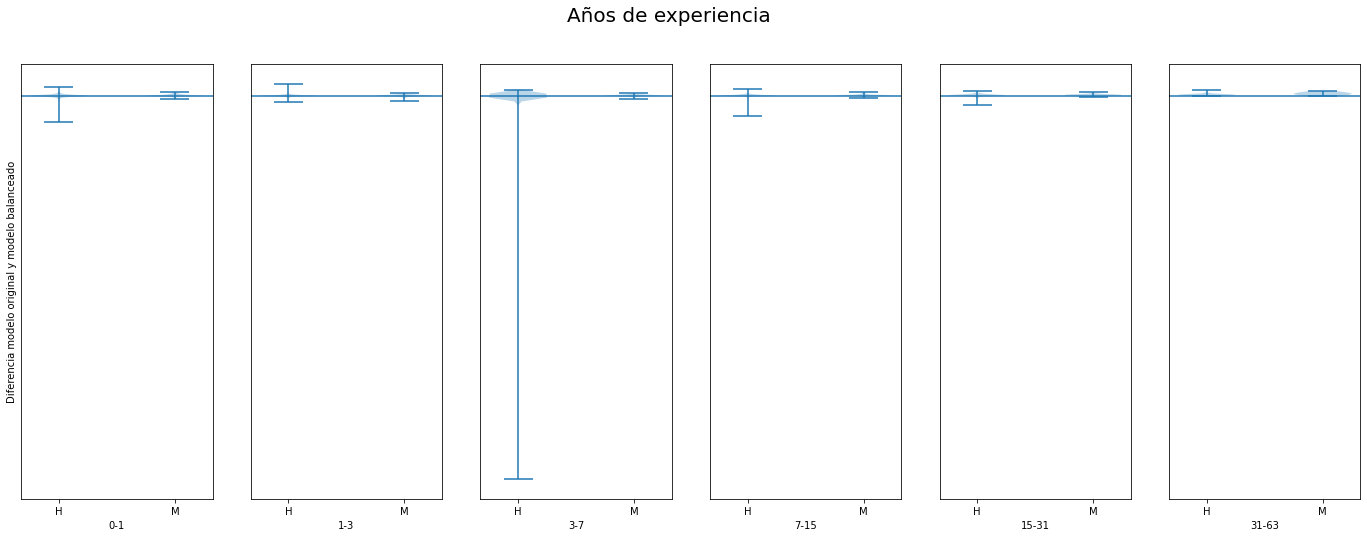

In [27]:
ax = None
f, axs = plt.subplots(2, len(exps),figsize=(4*len(exps), 8))
f.suptitle('Años de experiencia', fontsize=20)
for i, exp in enumerate(exps):
    ax = plt.subplot(1, len(exps), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo original y modelo balanceado')
    else:
        ax.set_yticks([])
    ax.set_xlabel(exp)
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['e_g_diff_weighted(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['e_g_diff_weighted(salary)'].values,
    ]);

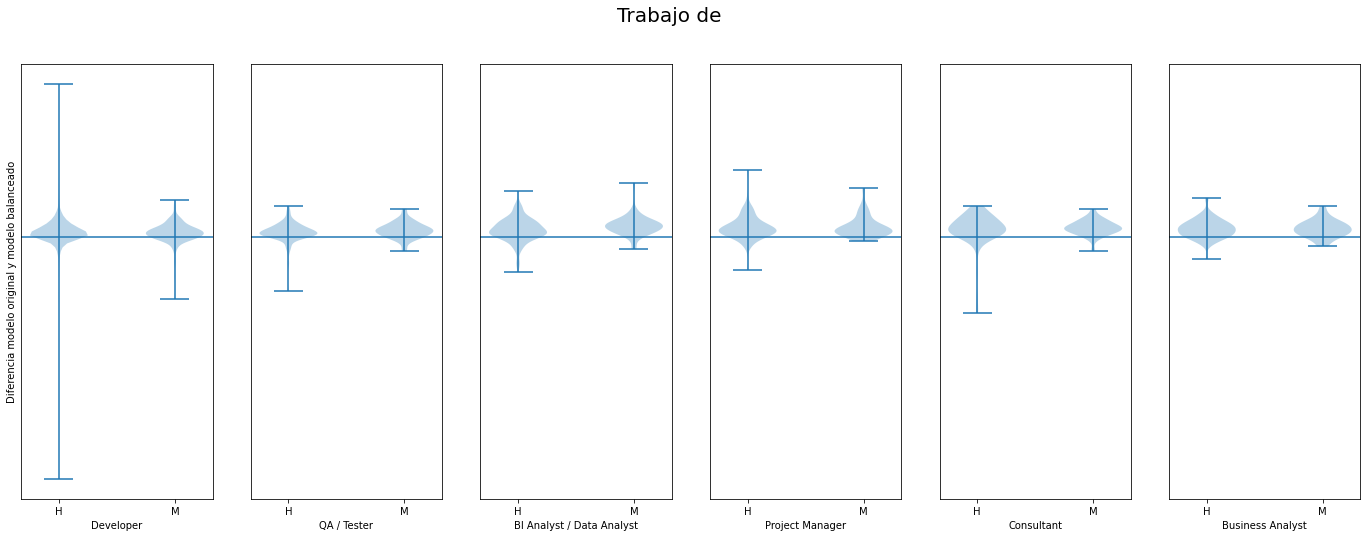

In [28]:
ax = None
f, axs = plt.subplots(1, len(occupations),figsize=(4*len(occupations), 8))
f.suptitle('Trabajo de', fontsize=20)
for i, occupation in enumerate(occupations):
    ax = plt.subplot(1, len(occupations), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo original y modelo balanceado')
    else:
        ax.set_yticks([])
    ax.set_xlabel(occupation)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['e_g_diff_weighted(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['e_g_diff_weighted(salary)'].values,
    ]);

In [29]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Hombre']['e_weighted(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Mujer']['e_weighted(salary)']))
print('r2 total', r2_score(df['Salario mensual BRUTO (en tu moneda local)'], df['e_weighted(salary)']))

r2 hombre 0.4706043595430035
r2 mujer 0.3442756142932991
r2 total 0.46216740069721907


Parece sorprendente que el r2 de las mujeres baje siendo que les estamos dando más peso. Sin embargo tienen más peso en el entrenamiento pero el calculo de r2 no cambia. Esto quiere decir que al darle menos peso a los hombres (el peso es ganancia cero) estamos perdiendo información que era útil para explicar las variaciones salariales. Sin embargo vemos que el promedio de sueldo de las mujeres mejora alrededor de 2% por encima del de los hombres, lo que quiere decir que por esta penalidad en que incurrimos, la brecha se achica.

## Clasificador

Me intriga pensar cuán posible es determinar el género de una persona dadas sus otras respuestas. Antes vimos que sacar género no generaba un proxy claro, pero si con una combinación de características se puede determinar el género de alguien, el modelo puede identificarlo implícitamente.

El modelo va a tener la misma entrada que el anterior, excepto género, y la salida va a ser 1 para Mujer y 0 para Hombre. Para evaluarlo tenemos que ver cómo establecer el corte. El modelo va a dar un número entre 0 y 1, mientras más cercano a 1 más parecerá que es un mujer, pero de alguna forma hay que agarrar este número y transformarlo en binario. Hay que considerar que al evaluar tenemos un desbalanceo de los datos, alrededor de 6 hombres por mujer, así que un modelo que diga siempre hombre tiene un 85% de _accuracy_. Vamos a balancear esto diciendo que el corte debería generar la misma proporción de errores de cada tipo, es decir, de hombre que predice como mujer y de mujeres que predice como hombres.

Técnicamente estamos hablado de la accuracy _balanceada_. Un modelo aleatorio tendría un 50% en esta métricas.

In [34]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
class GModel:
    def __init__(self, **params):
        self.classifier_ = xgb.XGBClassifier(**params)

    def get_params(self, deep=True):
        return self.classifier_.get_params(deep=deep)

    def set_params(self, **params):
        return self.classifier_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.classifier_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.classifier_.predict(X.apply(self.encode_row, axis=1).astype(float))
   
    def predict_proba(self, X):
        return self.classifier_.predict_proba(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return self.classifier_.score(X.apply(self.encode_row, axis=1).astype(float), y)

In [35]:
from sklearn.metrics import recall_score, precision_score

kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_gmodels = []
for train_index, test_index in kf.split(df):
    men_per_woman = (df.iloc[train_index]['Me identifico'] == 'Hombre').sum() / (df.iloc[train_index]['Me identifico'] == 'Mujer').sum()
    model = GModel().fit(
        df.iloc[train_index],
        (df.iloc[train_index]['Me identifico'] == 'Mujer').astype(float),
       sample_weight=df.iloc[train_index]['Me identifico'].apply(lambda g: 1.0 if g == 'Hombre' else men_per_woman)
    )
    df.loc[df.index[test_index], 'e(gender)'] = model.predict_proba(df.iloc[test_index])[:, 1]
    kf_gmodels.append(model)

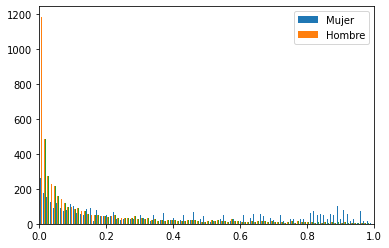

In [36]:
plt.xlim(0, 1)
plt.hist([
    df[df['Me identifico'] == 'Mujer']['e(gender)'].values,
    df[df['Me identifico'] == 'Hombre']['e(gender)'].values,
], weights=[
    np.ones((df['Me identifico'] == 'Mujer').sum()) * (df['Me identifico'] == 'Hombre').sum()/(df['Me identifico'] == 'Mujer').sum(),
    np.ones((df['Me identifico'] == 'Hombre').sum()),
], bins=100, label=['Mujer', 'Hombre']);
plt.legend(loc='upper right');

''

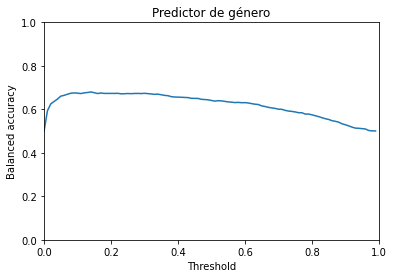

In [37]:
values = {}
for i in range(0, 100):
    values[i/100] = balanced_accuracy_score(df['Me identifico'] == 'Mujer', df['e(gender)'] > i / 100)
ax = pd.Series(values).plot()
ax.set_xlabel('Threshold')
ax.set_xlim(0, 1)
ax.set_ylabel('Balanced accuracy')
ax.set_ylim(0, 1.0)
ax.set_title('Predictor de género')
;

El modelo predictor de género acierta, como máximo, un 70% de las veces, un poco mejor que el 50% de base. No parece ser fácil establecer el género de una persona sólo con sus respuestas.

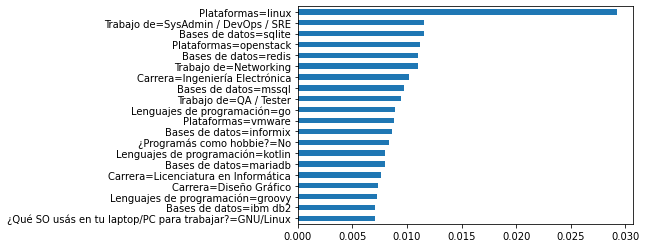

In [38]:
pd.Series(dict(zip(kf_gmodels[0].valid_words_ + [
'¿Gente a cargo?',
'Años de experiencia',
'Tengo',
],
kf_gmodels[0].classifier_.feature_importances_))).sort_values().tail(20).plot.barh();

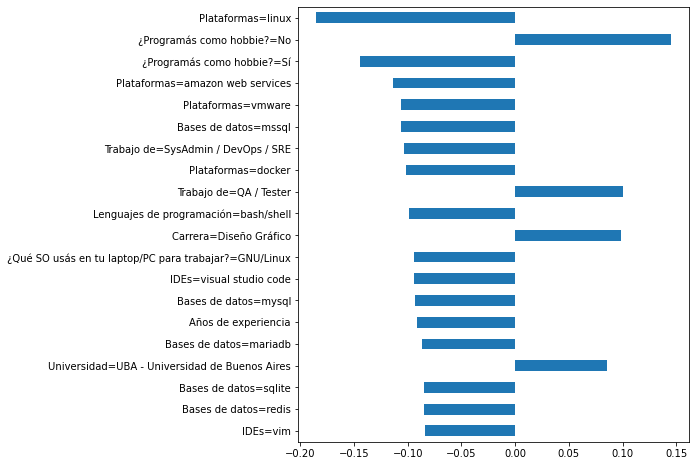

In [40]:
col_to_name = dict(zip(range(len(kf_gmodels[0].valid_words_)+3), kf_gmodels[0].valid_words_ + ['¿Gente a cargo?','Años de experiencia','Tengo',]))

df_encoded = df.apply(kf_gmodels[0].encode_row, axis=1)
df_corr = pd.concat((df_encoded, pd.DataFrame((df['Me identifico'] == 'Mujer').rename('Mujer'))), axis=1).corr()
df_corr['sort'] = np.abs(df_corr['Mujer'])
df_corr = df_corr.sort_values('sort')['Mujer'].drop('Mujer').tail(20).rename(lambda col: col_to_name[col], axis=1).plot.barh(figsize=(7, 8));